# Heat Stress Project - Milk Yield

# R Packages

In [1]:
suppressPackageStartupMessages({
  library(mgcv)
  library(arrow)
  library(dplyr)
  library(tictoc)
  library(fixest)
  library(plm)
  library(lspline)
  library(lmerTest)
  library(ggplot2)
  library(car)
  library(tidyverse)
  library(lmtest)
  library(rsample)
  library(rlang)
})
options(width=1000)

# Experiment Parameters

In [2]:
set.seed(2024)
period <- 1999:2023
month <- 4:10
start <- min(period)
stop <- max(period)
subsample <- F
diagnostic <- F
save <- F
sample_size <- 100000
dependent_var <- "milk_fpcm"
weather_var <- "thi_max_t2"
breeds <- c("HO", "JE", "SI", "SF", "BS", "OB")
start_knot <- 60
stop_knot <- 75
concatenated_string <- paste0("17_reduced_form_model_thi_mean_t0_3d_fixed_effect_", start, "-", stop, "_", format(Sys.time(), "%Y_%m_%d_%H_%M_%S"), "_", dependent_var)
concatenated_string

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1999-2023_2024_07_01_00_58_47_milk_fpcm"

# Custom Functions

In [3]:
generate_diagnostic_plots <- function(model) {
  # Extract fitted values and residuals
  fitted_values <- fitted(model)
  residuals <- residuals(model)
  
  # Create a data frame for plotting
  plot_data <- data.frame(fitted_values = fitted_values, residuals = residuals)
  print(nrow(plot_data))
  
  # Residuals vs Fitted Values Plot / Linearity & Homoscedacity
  p1 <- ggplot(plot_data, aes(x = fitted_values, y = residuals)) +
    geom_point(alpha = 0.5) +                       # Scatter plot of residuals
    geom_smooth(method = "loess", col = "red", se = FALSE) +    # Smooth curve (loess)
    labs(title = "Residuals vs. Fitted Values",
         x = "Fitted Values",
         y = "Residuals") +
    theme_minimal() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "blue")
  
  # Normal distribution of residuals
  p2 <- ggplot(plot_data, aes(sample = residuals)) +
    stat_qq() +
    stat_qq_line() +
    labs(title = "Normal Q-Q",
         x = "Theoretical Quantiles",
         y = "Residuals") +
    theme_minimal()
  
  # Scale-Location Plot (Homoscedacity - normally distributed standard error)
  plot_data$std_residuals <- scale(residuals)
  plot_data$abs_sqrt_residuals <- sqrt(abs(plot_data$std_residuals))
  
  p3 <- ggplot(plot_data, aes(fitted_values, abs_sqrt_residuals)) +
    geom_point() +
    geom_smooth(method = "loess", col = "red", se = FALSE) +
    labs(title = "Scale-Location Plot",
         x = "Fitted values",
         y = "√|Standardized residuals|") +
    theme_minimal()

  p4 <- ggplot(plot_data, aes(x = residuals)) +
    geom_histogram(binwidth = 0.5, fill = "blue", color = "black") +
    labs(title = "Histogram of Residuals", x = "Residuals", y = "Frequency") +
    theme_minimal()
 
  # Return the plots as a list
  list(
    Residuals_vs_Fitted = p1,
    Normal_QQ = p2,
    Scale_Location = p3,
    Residual_hist = p4
  )
}

In [4]:
create_effect_plot <- function(data, model, knot, response_var, predictor_var, breed) {
  # Create the range for the predictor variable
  predictor_range <- seq(ceiling(min(data[predictor_var], na.rm = TRUE)), floor(max(data[predictor_var], na.rm = TRUE)))
  # Calculate the effect
  effect <- lspline(predictor_range, knots = knot) %*% coeftest(model)[,1][1:(length(knot)+1)]
  
  # Calculate the confidence intervals
  effect_error_min <- effect - ((lspline(predictor_range, knots = knot)) %*% (abs(coeftest(model)[,2][1:(length(knot)+1)] * 1.96)))
  effect_error_max <- effect + ((lspline(predictor_range, knots = knot)) %*% (abs(coeftest(model)[,2][1:(length(knot)+1)] * 1.96)))
  
  # Create the data frame for plotting
  data_plot <- data.frame(
    breed = breed,
    predictor_range, 
    Effect = effect, 
    Lower = effect_error_min, 
    Upper = effect_error_max
  )
  
  # Create the plot
  plot <- ggplot(data_plot, aes(x = predictor_range, y = Effect)) +
    geom_line(color = "blue") +
    geom_ribbon(aes(ymin = Lower, ymax = Upper), alpha = 0.3, fill = "blue") +
    labs(
      title = paste("Effect of", predictor_var, "with Confidence Intervals"),
      x = paste(predictor_var, "Range"),
      y = "Effect"
    ) +
    theme_minimal() + 
    scale_x_continuous(breaks = seq(40, 90, by = 10), limits = c(40, max(predictor_range))) +
    theme(
      plot.title = element_text(hjust = 0.5),
      plot.title.position = "plot",
      axis.title.x = element_text(hjust = 0.5),
      axis.title.y = element_text(hjust = 0.5)
    )
  
  return(list(plot = plot, data = data_plot))
}

merge_plot_data <- function(plot_data_list) {
  # Combine the data frames from each plot into one data frame
  merged_data <- bind_rows(plot_data_list)
  
  return(merged_data)
}

# Load Data

In [5]:
milk_data <- read_parquet("/home/aschneuwl/workspace/agecon-thesis/notebooks/02_models/12_base_data.parquet")

In [6]:
milk_data$animalBreedCode <- as.factor(milk_data$animalBreedCode)
milk_data$milk_fpcm <- milk_data$milk*(0.0337 + 0.116*milk_data$fat + 0.06*milk_data$protein)
milk_data$year <- as.factor(milk_data$year)
milk_data$farmId <- as.factor(milk_data$farmId)
milk_data$month <- as.factor(milk_data$month)
milk_data$logmilk <- log(milk_data$milk)
milkingMehtod <- as.factor(milk_data$milkingMethod)
milk_data$zip <- as.factor(milk_data$zip)
milk_data$days_in_milk <- as.numeric(milk_data$days_in_milk)
milk_data$days_in_milk <- milk_data$days_in_milk / 86400
milk_data$farm_year_interaction = interaction(milk_data$farmId, milk_data$year)
milk_data$farm_month_interaction = interaction(milk_data$farmId, milk_data$month)

milk_data$regular_season <- with(milk_data, 
    ifelse(month %in% c("3", "4", "5"), "spring",
    ifelse(month %in% c("6", "7", "8"), "summer",
    ifelse(month %in% c("9", "10", "11"), "fall", "winter"))))

# Convert the new variable to a factor
milk_data$regular_season <- as.factor(milk_data$regular_season)
milk_data$zip_regular_season <- interaction(milk_data$zip, milk_data$regular_season)

# Create the interaction term between farmId and month_range
milk_data$farmId_regular_season_interaction <- interaction(milk_data$farmId, milk_data$regular_season)

milk_data$farm_season <- with(milk_data, 
    ifelse(month %in% c("4", "5", "6", "7", "8", "9"), "grazing", "nongrazing"))

# Convert the new variable to a factor
milk_data$farm_season <- as.factor(milk_data$farm_season)

# Create the interaction term between farmId and farm_seasons
milk_data$farmId_farm_season_interaction <- interaction(milk_data$farmId, milk_data$farm_season)

In [7]:
milk_data <- subset(milk_data, year %in% period)
milk_data <- subset(milk_data, month %in% month)

In [8]:
if (subsample) { 
    milk_data <- milk_data %>%
      group_by(year, animalBreedCode) %>%
      sample_frac(sample_size/nrow(milk_data)) %>% drop_na(get(weather_var))
}

In [9]:
milk_data <- droplevels(milk_data)

split data for each breed

In [10]:
je <- droplevels(subset(milk_data, animalBreedCode %in% c("JE")) %>% drop_na(!!weather_var))
bs <- droplevels(subset(milk_data, animalBreedCode %in% c("BS")) %>% drop_na(!!weather_var))
ho <- droplevels(subset(milk_data, animalBreedCode %in% c("HO")) %>% drop_na(!!weather_var))
ob <- droplevels(subset(milk_data, animalBreedCode %in% c("OB")) %>% drop_na(!!weather_var))
si <- droplevels(subset(milk_data, animalBreedCode %in% c("SI")) %>% drop_na(!!weather_var))
sf <- droplevels(subset(milk_data, animalBreedCode %in% c("SF")) %>% drop_na(!!weather_var))

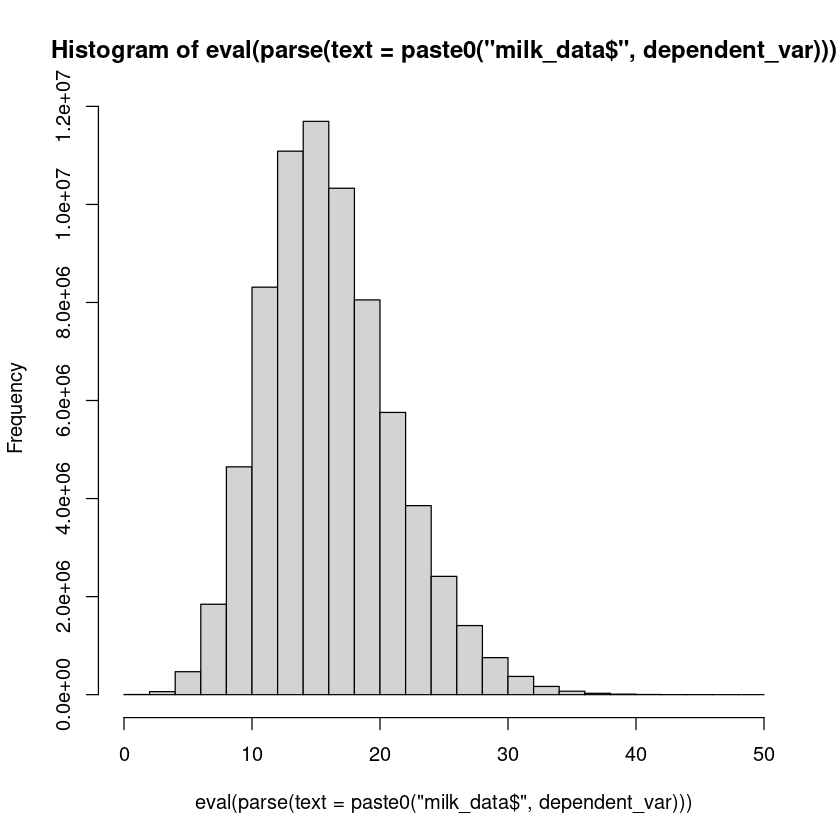

In [11]:
hist(eval(parse(text = paste0("milk_data$", dependent_var))))

In [12]:
rm(milk_data)

# Piecewise Linear THI - Reduced Form Piecewise Linear Fixed Effect Model

In [13]:
pl_clu <- c("year", "animalId")

run_models_with_knots <- function(data, knot_sequence, dep_var_name, weather_var) {
  best_rss <- Inf
  best_knot_comb <- NULL
  
  # Loop over each knot value
  for (i in 1:length(knot_sequence)) {
    knots <- paste(knot_sequence[[i]], collapse = ",")
    
    f <- paste0(dep_var_name, "~", "lspline(", weather_var, ", knots=c(", knots, ")) + days_in_milk + lactationNumber + precip_mean_t0_3d + precip_mean_t0_3d^2 + year | animalId")
    pl_form <- as.formula(f)
    model <- feols(pl_form, data = data, cluster = pl_clu)
    
    # Calculate RSS for the current model
    current_rss <- sum(residuals(model)^2)
    
    # Check if this model has the lowest RSS so far
    if (current_rss < best_rss) {
      best_rss <- current_rss
      best_knot_comb <- knot_sequence[[i]]
    }
  }
  
  # Recompute the best model for storage reasons
  knots <- paste(best_knot_comb, collapse = ",")
  f <- paste0(dep_var_name, "~", "lspline(", weather_var, ", knots=c(", knots, ")) + days_in_milk + lactationNumber + precip_mean_t0_3d + precip_mean_t0_3d^2 + year | animalId")
  pl_form <- as.formula(f)
  best_model <- feols(pl_form, data = data, cluster = pl_clu, lean = T)
  gc()
  
  # Return a list containing the best knot combination, the best model, and its RSS
  return(list(best_knot = best_knot_comb, best_model_rss = best_rss, best_model = best_model))
}



In [14]:
knot_combs <- list()
for (i in start_knot:stop_knot) {
    j <- i - start_knot + 1
  knot_combs[[j]] <- c(i)
}

In [15]:
#knot_combs[[length(knot_combs)+1]] <- seq(from = 0, to = 80, by = 5)

## Jersey

In [16]:
tic()
je_model = run_models_with_knots(droplevels(je), knot_combs, dependent_var, weather_var)
toc()

18.116 sec elapsed


In [17]:
jersey_model_name <- paste0(concatenated_string, "_jersey_model.Rdata")
jersey_model_name

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1999-2023_2024_07_01_00_58_47_milk_fpcm_jersey_model.Rdata"

In [18]:
if (save) {
    tic()
    saveRDS(je_model, file = jersey_model_name, compress=T)
    toc()
}

In [19]:
je_model$best_knot

[1] 60

In [20]:
summary(je_model$best_model)

OLS estimation, Dep. Var.: milk_fpcm
Observations: 660,110
Fixed-effects: animalId: 26,641
Standard-errors: Clustered (year & animalId) 
                                     Estimate Std. Error    t value   Pr(>|t|)    
lspline(thi_max_t2, knots = c(60))1 -0.003106   0.001518  -2.045898 5.1875e-02 .  
lspline(thi_max_t2, knots = c(60))2 -0.061729   0.004018 -15.363941 6.4342e-14 ***
days_in_milk                        -0.020356   0.000227 -89.778625  < 2.2e-16 ***
lactationNumber                     -0.063952   0.074165  -0.862301 3.9706e-01    
precip_mean_t0_3d                   -0.005410   0.004153  -1.302700 2.0504e-01    
I(precip_mean_t0_3d^2)              -0.000223   0.000144  -1.542398 1.3606e-01    
year2000                             0.644415   0.170721   3.774658 9.2929e-04 ***
year2001                             2.170654   0.261475   8.301585 1.6292e-08 ***
year2002                             3.251341   0.304173  10.689102 1.3169e-10 ***
year2003                         

Warning message:
“Removed 39 rows containing missing values or values outside the scale range (`geom_line()`).”


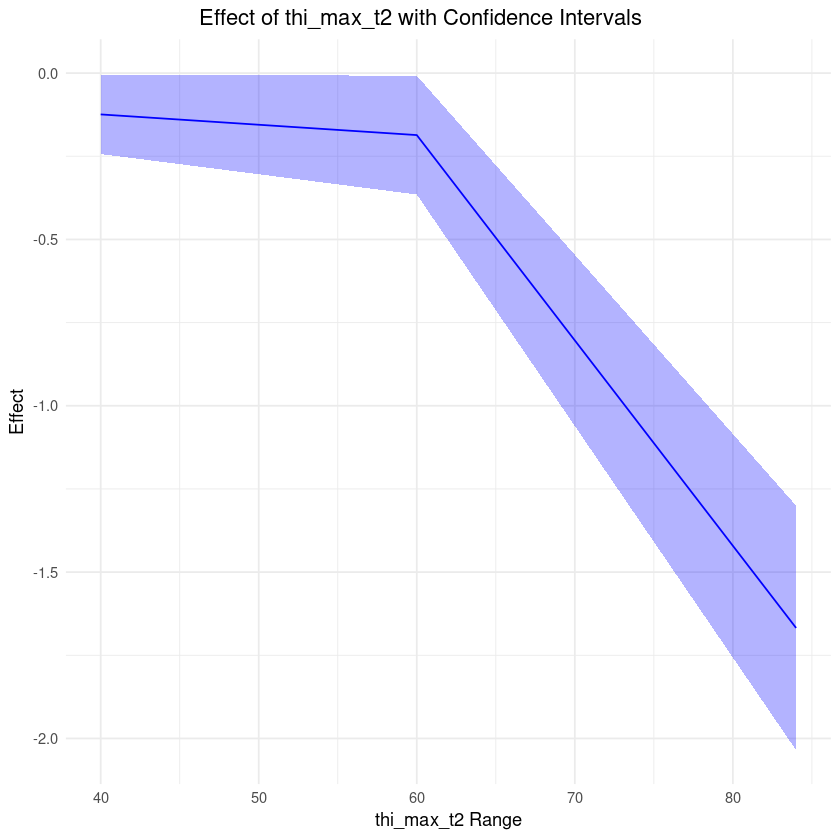

In [21]:
je_p <- create_effect_plot(je, je_model$best_model, je_model$best_knot, dependent_var, weather_var, "JE")
je_p$plot

## Holstein

In [22]:
tic()
ho_model = run_models_with_knots(ho, knot_combs, dependent_var, weather_var)
toc()

439.607 sec elapsed


In [23]:
ho_model_name <- paste0(concatenated_string, "_ho_model.Rdata")
ho_model_name

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1999-2023_2024_07_01_00_58_47_milk_fpcm_ho_model.Rdata"

In [24]:
if (save) {
    tic()
    saveRDS(ho_model, file = ho_model_name, compress=TRUE)
    toc()
}

In [25]:
ho_model$best_knot

[1] 60

In [26]:
summary(ho_model$best_model)

OLS estimation, Dep. Var.: milk_fpcm
Observations: 22,273,344
Fixed-effects: animalId: 1,017,805
Standard-errors: Clustered (year & animalId) 
                                     Estimate Std. Error    t value   Pr(>|t|)    
lspline(thi_max_t2, knots = c(60))1 -0.001731   0.001315  -1.316421 2.0047e-01    
lspline(thi_max_t2, knots = c(60))2 -0.065172   0.003722 -17.511259 3.5693e-15 ***
days_in_milk                        -0.029177   0.000483 -60.392677  < 2.2e-16 ***
lactationNumber                      0.046996   0.079059   0.594441 5.5778e-01    
precip_mean_t0_3d                    0.001664   0.003220   0.516924 6.0994e-01    
I(precip_mean_t0_3d^2)              -0.000191   0.000114  -1.678659 1.0619e-01    
year2000                             0.570636   0.127288   4.483013 1.5465e-04 ***
year2001                             1.366311   0.230679   5.923007 4.1187e-06 ***
year2002                             1.919931   0.317987   6.037772 3.1053e-06 ***
year2003                   

Warning message:
“Removed 41 rows containing missing values or values outside the scale range (`geom_line()`).”


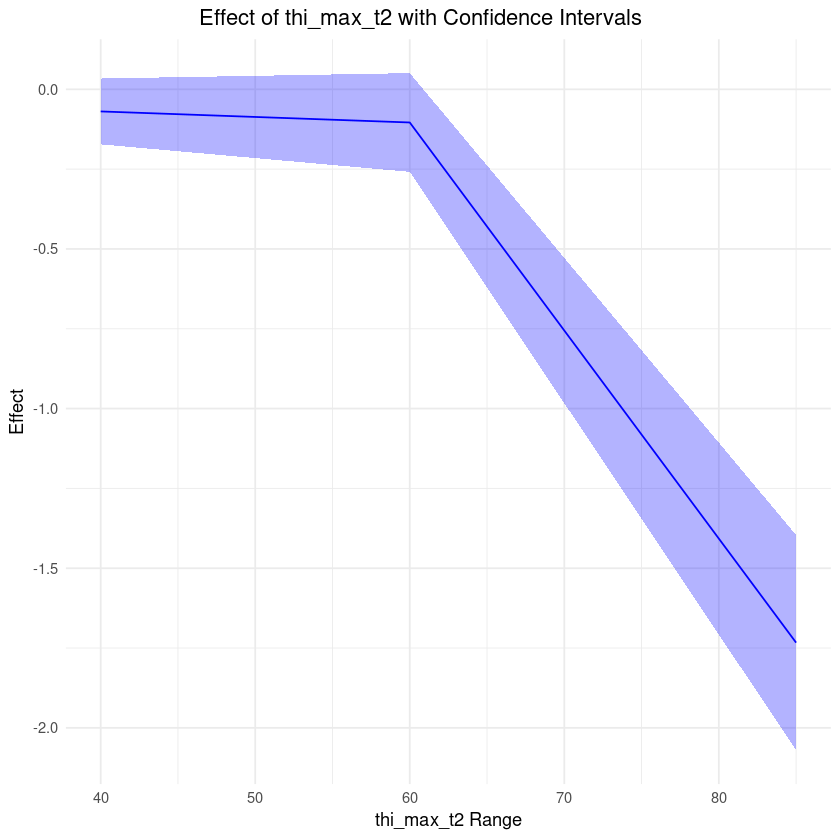

In [27]:
ho_p <- create_effect_plot(ho, ho_model$best_model, ho_model$best_knot, dependent_var, weather_var, "HO")
ho_p$plot

## Brown Swiss

In [28]:
tic()
bs_model = run_models_with_knots(bs, knot_combs, dependent_var, weather_var)
toc()

702.853 sec elapsed


In [29]:
bs_model_name <- paste0(concatenated_string, "_bs_model.Rdata")
bs_model_name

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1999-2023_2024_07_01_00_58_47_milk_fpcm_bs_model.Rdata"

In [30]:
if (save) {
    tic()
    saveRDS(bs_model, file = bs_model_name, compress=T)
    toc()
}

In [31]:
bs_model$best_knot

[1] 60

In [32]:
summary(bs_model$best_model)

OLS estimation, Dep. Var.: milk_fpcm
Observations: 29,798,989
Fixed-effects: animalId: 1,228,051
Standard-errors: Clustered (year & animalId) 
                                     Estimate Std. Error    t value   Pr(>|t|)    
lspline(thi_max_t2, knots = c(60))1 -0.008337   0.001666  -5.005490 4.0994e-05 ***
lspline(thi_max_t2, knots = c(60))2 -0.051280   0.003587 -14.297419 3.0711e-13 ***
days_in_milk                        -0.024607   0.000315 -78.028051  < 2.2e-16 ***
lactationNumber                     -0.010421   0.075178  -0.138614 8.9091e-01    
precip_mean_t0_3d                   -0.006442   0.002640  -2.439823 2.2457e-02 *  
I(precip_mean_t0_3d^2)               0.000036   0.000098   0.368854 7.1547e-01    
year2000                             0.336444   0.083997   4.005442 5.1971e-04 ***
year2001                             1.279743   0.156019   8.202495 2.0219e-08 ***
year2002                             1.636159   0.228882   7.148471 2.1787e-07 ***
year2003                   

Warning message:
“Removed 41 rows containing missing values or values outside the scale range (`geom_line()`).”


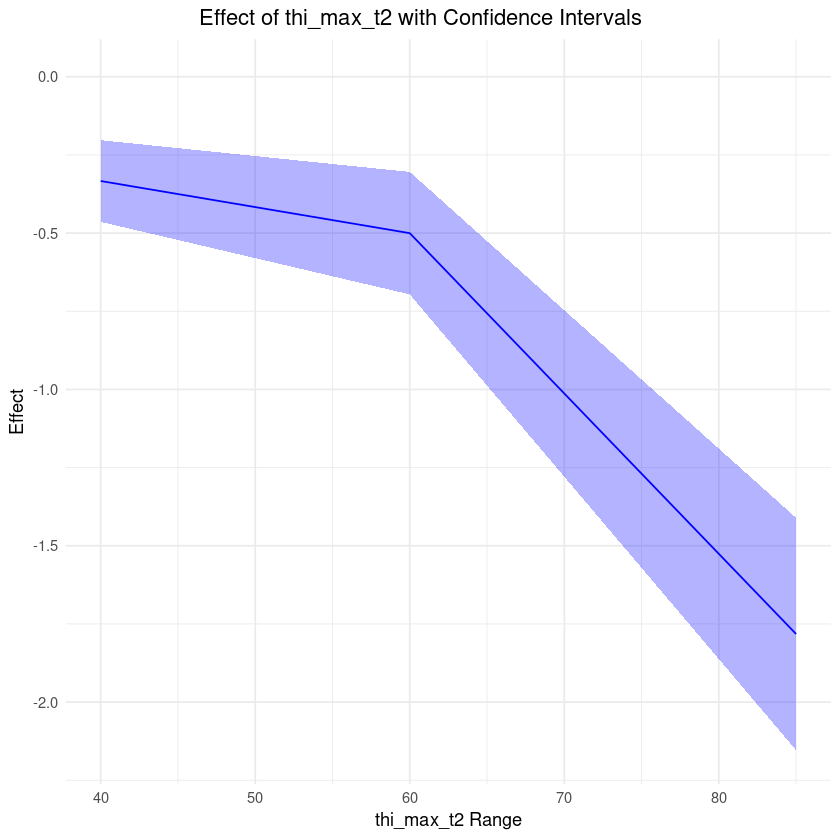

In [33]:
bs_p <- create_effect_plot(bs, bs_model$best_model, bs_model$best_knot, dependent_var, weather_var, "BS")
bs_p$plot

## Simmental

In [34]:
tic()
si_model = run_models_with_knots(si, knot_combs, dependent_var, weather_var)
toc()

85.194 sec elapsed


In [35]:
si_model_name <- paste0(concatenated_string, "_si_model.Rdata")
si_model_name

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1999-2023_2024_07_01_00_58_47_milk_fpcm_si_model.Rdata"

In [36]:
if (save) {
    tic()
    saveRDS(si_model, file = si_model_name, compress=T)
    toc()
}

In [37]:
si_model$best_knot

[1] 60

In [38]:
summary(si_model$best_model)

OLS estimation, Dep. Var.: milk_fpcm
Observations: 3,754,197
Fixed-effects: animalId: 172,306
Standard-errors: Clustered (year & animalId) 
                                     Estimate Std. Error    t value   Pr(>|t|)    
lspline(thi_max_t2, knots = c(60))1  0.007676   0.001162    6.60408 7.8676e-07 ***
lspline(thi_max_t2, knots = c(60))2 -0.054049   0.004077  -13.25576 1.5505e-12 ***
days_in_milk                        -0.026321   0.000240 -109.86030  < 2.2e-16 ***
lactationNumber                     -0.370978   0.072937   -5.08630 3.3408e-05 ***
precip_mean_t0_3d                    0.003576   0.003174    1.12689 2.7093e-01    
I(precip_mean_t0_3d^2)              -0.000272   0.000131   -2.08458 4.7921e-02 *  
year2000                             0.419234   0.085219    4.91951 5.0981e-05 ***
year2001                             1.119706   0.162584    6.88696 4.0186e-07 ***
year2002                             1.545497   0.238524    6.47942 1.0611e-06 ***
year2003                      

Warning message:
“Removed 39 rows containing missing values or values outside the scale range (`geom_line()`).”


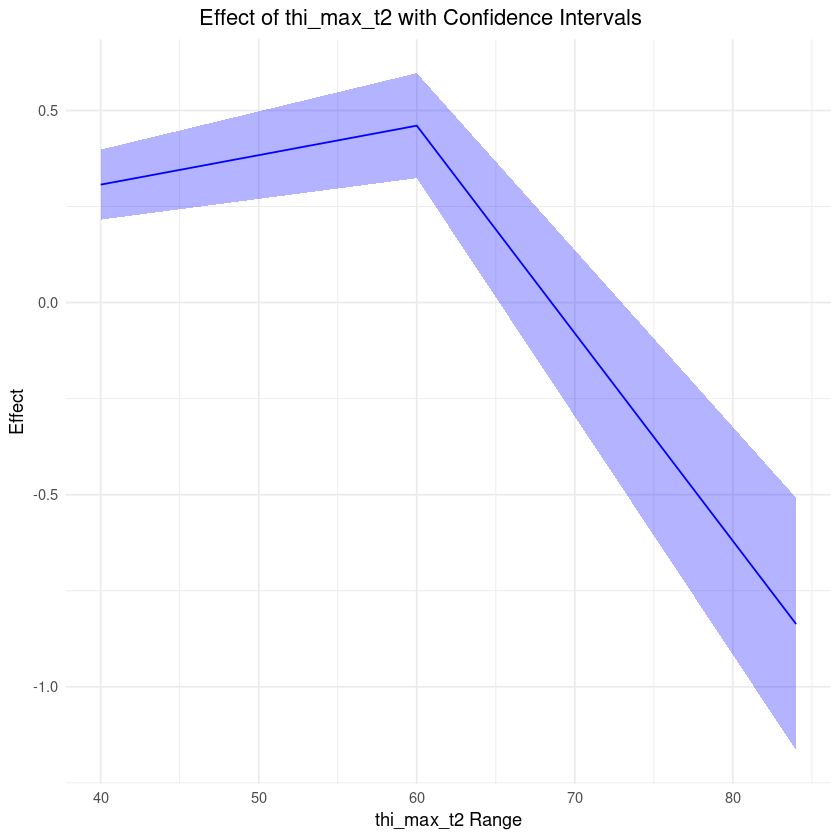

In [39]:
si_p <- create_effect_plot(si, si_model$best_model, si_model$best_knot, dependent_var, weather_var, "SI")
si_p$plot

## Swiss Fleckvieh

In [40]:
tic()
sf_model = run_models_with_knots(sf, knot_combs, dependent_var, weather_var)
toc()

268.492 sec elapsed


In [41]:
sf_model_name <- paste0(concatenated_string, "_sf_model.Rdata")
sf_model_name

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1999-2023_2024_07_01_00_58_47_milk_fpcm_sf_model.Rdata"

In [42]:
if (save) {
    tic()
    saveRDS(sf_model, file = sf_model_name, compress=T)
    toc()
}

In [43]:
sf_model$best_knot

[1] 61

In [44]:
summary(sf_model$best_model)

OLS estimation, Dep. Var.: milk_fpcm
Observations: 13,073,097
Fixed-effects: animalId: 570,197
Standard-errors: Clustered (year & animalId) 
                                     Estimate Std. Error    t value   Pr(>|t|)    
lspline(thi_max_t2, knots = c(61))1  0.006178   0.001189   5.196307 2.5299e-05 ***
lspline(thi_max_t2, knots = c(61))2 -0.057865   0.003389 -17.072339 6.2842e-15 ***
days_in_milk                        -0.029447   0.000316 -93.171409  < 2.2e-16 ***
lactationNumber                     -0.062973   0.081336  -0.774236 4.4635e-01    
precip_mean_t0_3d                   -0.000226   0.002775  -0.081346 9.3584e-01    
I(precip_mean_t0_3d^2)              -0.000087   0.000102  -0.851414 4.0296e-01    
year2000                             0.431252   0.093841   4.595543 1.1615e-04 ***
year2001                             1.120646   0.166795   6.718723 5.9853e-07 ***
year2002                             1.545301   0.247665   6.239475 1.8965e-06 ***
year2003                     

Warning message:
“Removed 41 rows containing missing values or values outside the scale range (`geom_line()`).”


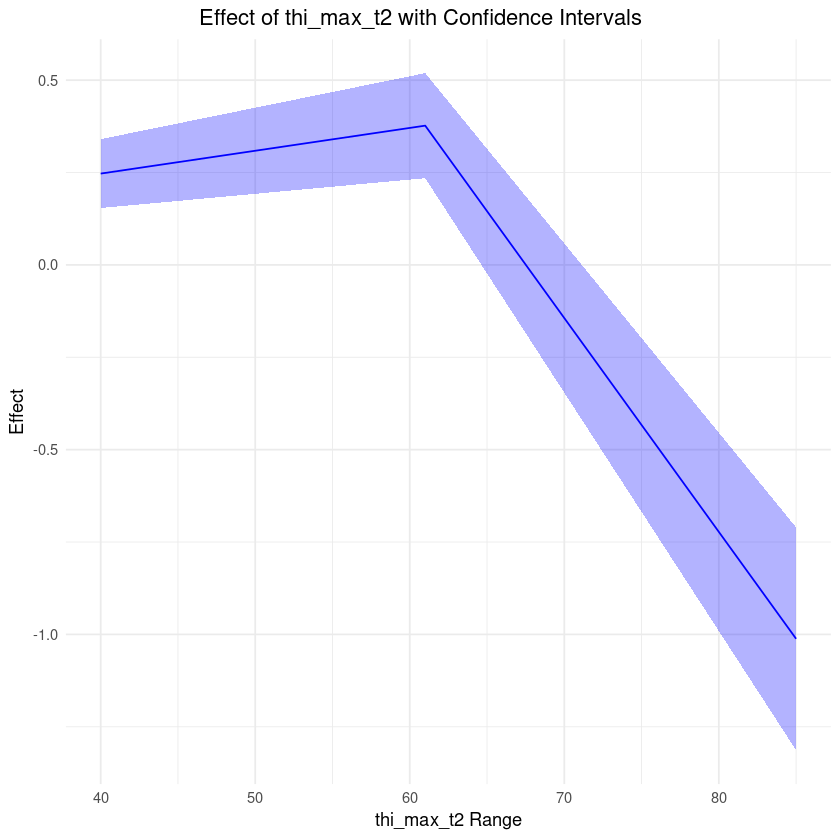

In [45]:
sf_p <- create_effect_plot(sf, sf_model$best_model, sf_model$best_knot, dependent_var, weather_var, "SF")
sf_p$plot

# Original Braunvieh

In [46]:
tic()
ob_model = run_models_with_knots(ob, knot_combs, dependent_var, weather_var)
toc()

32.571 sec elapsed


In [47]:
ob_model_name <- paste0(concatenated_string, "_ob_model.Rdata")
ob_model_name

[1] "17_reduced_form_model_thi_mean_t0_3d_fixed_effect_1999-2023_2024_07_01_00_58_47_milk_fpcm_ob_model.Rdata"

In [48]:
if (save) {
    tic()
    saveRDS(ob_model, file = ob_model_name, compress=T)
    toc()
}

In [49]:
ob_model$best_knot

[1] 60

In [50]:
summary(ob_model$best_model)

OLS estimation, Dep. Var.: milk_fpcm
Observations: 1,785,084
Fixed-effects: animalId: 74,940
Standard-errors: Clustered (year & animalId) 
                                     Estimate Std. Error     t value   Pr(>|t|)    
lspline(thi_max_t2, knots = c(60))1 -0.000455   0.001363   -0.333702 7.4150e-01    
lspline(thi_max_t2, knots = c(60))2 -0.042285   0.003911  -10.810539 1.0503e-10 ***
days_in_milk                        -0.023398   0.000174 -134.344254  < 2.2e-16 ***
lactationNumber                     -0.221435   0.059404   -3.727609 1.0455e-03 ** 
precip_mean_t0_3d                    0.000273   0.003754    0.072808 9.4256e-01    
I(precip_mean_t0_3d^2)              -0.000064   0.000138   -0.461518 6.4858e-01    
year2000                             0.366592   0.075012    4.887101 5.5352e-05 ***
year2001                             1.169477   0.135595    8.624787 8.1297e-09 ***
year2002                             1.548237   0.197194    7.851354 4.3914e-08 ***
year2003             

Warning message:
“Removed 40 rows containing missing values or values outside the scale range (`geom_line()`).”


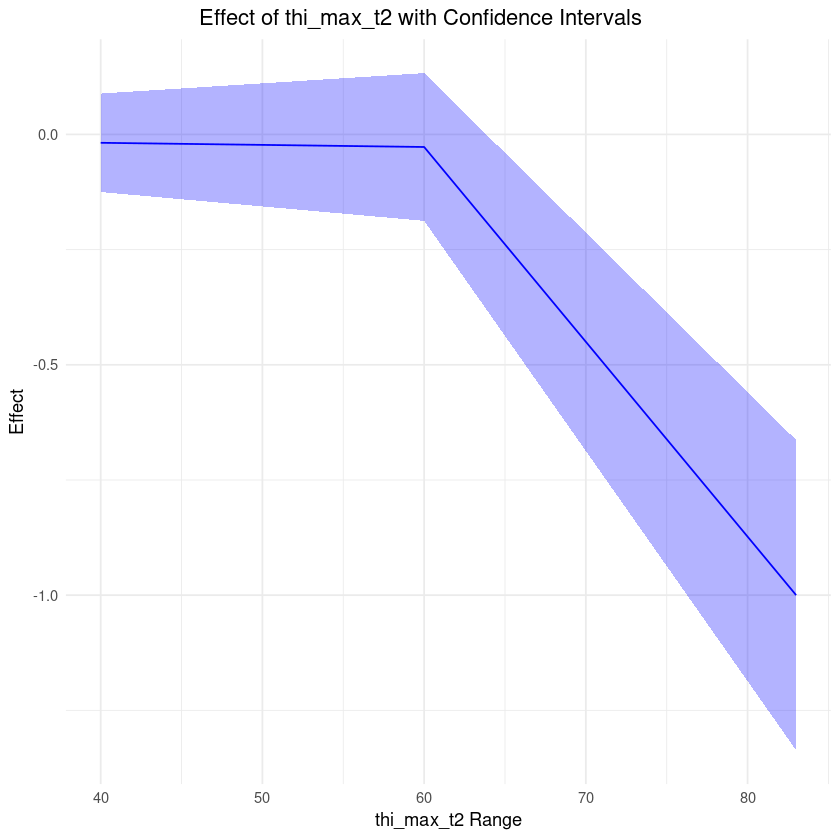

In [51]:
ob_p <- create_effect_plot(ob, ob_model$best_model, ob_model$best_knot, dependent_var, weather_var, "OB")
ob_p$plot

## Merge data

In [52]:
breed_effect_data <- merge_plot_data(list(ho_p$data, bs_p$data, sf_p$data, si_p$data, bs_p$data, je_p$data, ob_p$data))
saveRDS(breed_effect_data, file = paste0(concatenated_string, "_plot_data.Rdata"), compress=T)

In [53]:
# Function to plot merged data
plot_merged_data <- function(merged_data, predictor_var) {
  # Create the plot
    
    y_min <- min(merged_data$Lower)
    y_max <- max(merged_data$Upper)
    plot <- ggplot(merged_data, aes(x = predictor_range, y = Effect, color = breed, fill = breed)) +
    geom_line() +
    geom_ribbon(aes(ymin = Lower, ymax = Upper), alpha = 0.3) +
    labs(
      title = paste0("Effect of", predictor_var, " per breed"),
      x = "Predictor Variable Range",
      y = "Effect"
    ) +
    theme_minimal() +
    scale_x_continuous(breaks = seq(40,  max(merged_data$predictor_range), by = 10), limits = c(40, max(merged_data$predictor_range))) +
    scale_y_continuous(limits = c(y_min, y_max)) +
    theme(
      plot.title = element_text(hjust = 0.5),
      plot.title.position = "plot",
      axis.title.x = element_text(hjust = 0.5),
      axis.title.y = element_text(hjust = 0.5)
    ) +
    facet_wrap(~ breed)
  
  
  return(plot)
}

Warning message:
“Removed 282 rows containing missing values or values outside the scale range (`geom_line()`).”


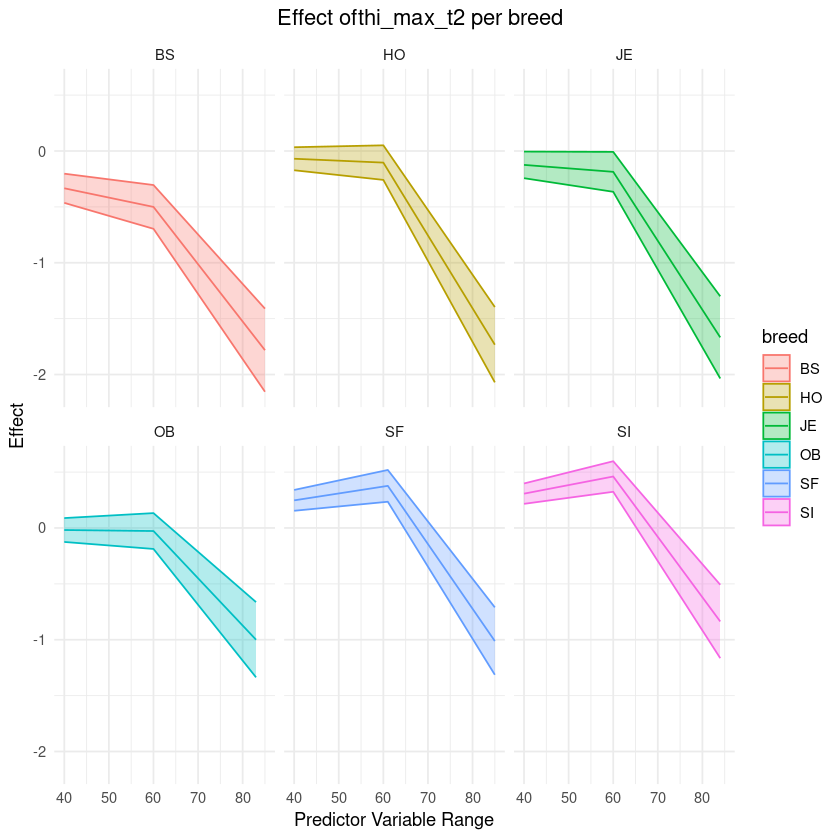

In [54]:
plot_merged_data(breed_effect_data, weather_var)